# Objective
Comparing kd-tree and ball tree in nearest neighbours search, as well as tuning the leaf_size parameter to speed up APTBPS as much as possible.

In [1]:
import pandas as pd
import numpy as np
import multiprocessing

from bps import bps
import aptbps
import os
from tqdm import tqdm
import h5py

In [73]:
# Modify as needed
MAIN_PATH = os.path.join('aptbps-code')
LOGS_PATH = os.path.join(MAIN_PATH, 'logs')
DATA_PATH = os.path.join(MAIN_PATH, 'data')

TRAIN_PATH = os.path.join(DATA_PATH, 'train')
HDF5_PATH = os.path.join(DATA_PATH, 'hdf5')
NO_UNLABELED_H5_PATH = os.path.join(DATA_PATH, 'no_unlabeled_hdf5')
HDF5_TRAIN_PATH = os.path.join(HDF5_PATH, 'train')
ENCODED_HDF5_PATH = os.path.join(DATA_PATH, 'tree_encoded_hdf5')

# All the clouds in the training dataset
train_files = [
    "bildstein_station1_xyz_intensity_rgb",
    "bildstein_station3_xyz_intensity_rgb",
    "bildstein_station5_xyz_intensity_rgb",
    "domfountain_station1_xyz_intensity_rgb",
    "domfountain_station2_xyz_intensity_rgb",
    "domfountain_station3_xyz_intensity_rgb",
    "neugasse_station1_xyz_intensity_rgb",
    "sg27_station1_intensity_rgb",
    "sg27_station2_intensity_rgb",
    "sg27_station4_intensity_rgb",
    "sg27_station5_intensity_rgb",
    "sg27_station9_intensity_rgb",
    "sg28_station4_intensity_rgb",
    "untermaederbrunnen_station1_xyz_intensity_rgb",
    "untermaederbrunnen_station3_xyz_intensity_rgb",
]

In [14]:
# batch of 100 point clouds to convert
x = np.random.normal(size=[10000, 4096, 3])

# optional point cloud normalization to fit a unit sphere
x_norm = bps.normalize(x)

In [23]:
# option 1: encode with 1024 random basis and distances as features
x_bps_random = bps.encode(x_norm, bps_arrangement='random', n_bps_points=2048, bps_cell_type='dists', nn_algo='kd_tree', leaf_size=30)

using 12 available CPUs for BPS encoding..


100%|██████████| 833/833 [00:07<00:00, 110.15it/s]


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [18]:
from time import time
from sklearn.neighbors import KDTree, BallTree

In [136]:
BPS_POINTS = 512

f_ext = train_files[0] + '.h5'
no_unlabeled_f_path = os.path.join(NO_UNLABELED_H5_PATH, f_ext)
with pd.HDFStore(no_unlabeled_f_path, compression='lz4', mode='r') as store2:
        
    # Selecting columns (like you would do with the command below) doesn't work.
    # This is because the HDFStore was created with the 'fixed' format, which doesn't allow select but has faster read/write performance.
    # 'table' format would allow selection. Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_hdf.html
    #test = pd.DataFrame(store2.select(key="0", columns=["x", "y", "z"]))
        
        # Due to this, we must first retrieve the store in its entirety.
    df = store2.get('0')
    
        # Select the xyz columns only for normalization
    df2 = df[['x','y','z']]
        
        
        # Convert to np array
    df_np = df2.to_numpy()
        
        # Add extra dimension to match the requirements of the bps library
    df_np = df_np[np.newaxis, :]
        
        # There's no need to reshape again, as I'm adding the newaxis before the other dims (so it becomes 1, n_points, 3)
        # However, just to make sure, I reshape it
    df_np = df_np.reshape(1, -1, 3)
        
        # Normalize cloud
        # Normalization must be done on the full cloud.
    df_np = bps.normalize(df_np)
        
        # -- DIVIDING ARRAY INTO TWO ARRAYS OF SIZE ~2048
        # To speed up BPS encoding, we can merge this list into two np arrays.
        # To obtain even data, we split each cloud into subclouds of ~2048;
        # Each 2048 subcloud is then bps-encoded to 512 points.
        
    n_points = df_np.shape[1]
    cloud_points = 2048
        
    # Remove extra dimension
    df_np = np.squeeze(df_np)
        
    # Floor division
    n_divisions = n_points//cloud_points
        
    # np.array_split returns l % n sub-arrays of size l//n + 1 and the rest of size l//n.
    # This means that the split index to achieve this is split_idx must be equal to (l%n * l//n+1)
    split_idx = (n_points % n_divisions) * (cloud_points + 1)
        
    arr1, arr2 = np.split(df_np, [split_idx])
    
    # Add extra dimension to hold the n. of clouds
    arr1 = arr1[np.newaxis, :]
    arr2 = arr2[np.newaxis, :]

    # Reshape to have n. of clouds as first dimension
    arr1 = arr1.reshape(-1, cloud_points+1, 3)
    arr2 = arr2.reshape(-1, cloud_points, 3)

In [59]:
# Pick random sample
arr1 = arr1.reshape(-1, 3)
rand_idx = np.random.choice(arr1.shape[0], 5000, replace=False)  
rand_arr1 = arr1[rand_idx]

(5000, 3)
[[-0.01922129 -0.06629872 -0.00960033]
 [-0.01424609 -0.11741554 -0.00626518]
 [-0.05375045 -0.0695238  -0.01043686]
 ...
 [-0.01725102 -0.12582494 -0.00538462]
 [-0.05427879 -0.17798743 -0.00268789]
 [-0.03285904 -0.16590166 -0.00305112]]


In [20]:
from time import time

def average_time(executable, *args, **kwargs):
    """Compute the average time over N runs"""
    N = 5
    t = 0
    for i in range(N):
        t0 = time()
        res = executable(*args, **kwargs)
        t1 = time()
        t += (t1 - t0)
    return res, t * 1. / N

# Source for knn time comparison functions used [here](https://jakevdp.github.io/blog/2013/04/29/benchmarking-nearest-neighbor-searches-in-python/#Scaling-with-Leaf-Size)

In [21]:
TREE_DICT = dict(KDTree=KDTree, BallTree=BallTree)
colors = dict(KDTree='red', BallTree='blue', brute='gray', gaussian_kde='black')

def bench_knn_query(tree_name, X, N, D, leaf_size, k,
                    build_args=None, query_args=None):
    """Run benchmarks for the k-nearest neighbors query"""
    Tree = TREE_DICT[tree_name]
    
    if build_args is None:
        build_args = {}
        
    if query_args is None:
        query_args = {}
        
    NDLk = np.broadcast(N, D, leaf_size, k)
        
    t_build = np.zeros(NDLk.size)
    t_query = np.zeros(NDLk.size)
    
    for i, (N, D, leaf_size, k) in enumerate(NDLk):
        XND = X[:N, :D]
        
        build_args['leaf_size'] = leaf_size
        
        tree, t_build[i] = average_time(Tree, XND, **build_args)
        res, t_query[i] = average_time(tree.query, XND, k, **query_args)
        
    return t_build, t_query

In [68]:
def plot_scaling(data, estimate_brute=False, suptitle='', **kwargs):
    """Plot the scaling comparisons for different tree types"""
    # Find the iterable key
    iterables = [key for (key, val) in kwargs.items() if hasattr(val, '__len__')]
    if len(iterables) != 1:
        raise ValueError("A single iterable argument must be specified")
    x_key = iterables[0]
    x = kwargs[x_key]
    
    # Set some defaults
    if 'N' not in kwargs:
        kwargs['N'] = data.shape[0]
    if 'D' not in kwargs:
        kwargs['D'] = data.shape[1]
    if 'leaf_size' not in kwargs:
        kwargs['leaf_size'] = 15
    if 'k' not in kwargs:
        kwargs['k'] = 1
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4),
                           subplot_kw=dict(yscale='log', xscale='log'))
        
    for tree_name in ['KDTree', 'BallTree']:
        t_build, t_query = bench_knn_query(tree_name, data, **kwargs)
        ax[0].plot(x, t_build, color=colors[tree_name], label=tree_name)
        ax[1].plot(x, t_query, color=colors[tree_name], label=tree_name)
        
        t_build, t_query = bench_knn_query(tree_name, data,
                                            query_args=dict(breadth_first=True, dualtree=True),
                                            **kwargs)
            
    if estimate_brute:
        Nmin = np.min(kwargs['N'])
        Dmin = np.min(kwargs['D'])
        kmin = np.min(kwargs['k'])
        
        # get a baseline brute force time by setting the leaf size large,
        # ensuring a brute force calculation over the data
        _, t0 = bench_knn_query('KDTree', data, N=Nmin, D=Dmin, leaf_size=2 * Nmin, k=kmin)
        
        # use the theoretical scaling: O[N^2 D]
        if x_key == 'N':
            exponent = 2
        elif x_key == 'D':
            exponent = 1
        else:
            exponent = 0
            
        t_brute = t0 * (np.array(x, dtype=float) / np.min(x)) ** exponent
        ax[1].plot(x, t_brute, color=colors['brute'], label='brute force (est.)')
            
    for axi in ax:
        axi.grid(True)
        axi.set_xlabel(x_key)
        axi.set_ylabel('time (s)')
        axi.legend(loc='upper left')
        axi.set_xlim(np.min(x), np.max(x))
        
    info_str = ', '.join([key + '={' + key + '}' for key in ['N', 'D', 'k'] if key != x_key])
    ax[0].set_title('Tree Build Time ({0})'.format(info_str.format(**kwargs)))
    ax[1].set_title('Tree Query Time ({0})'.format(info_str.format(**kwargs)))
    
    if suptitle:
        fig.suptitle(suptitle, size=16)
    
    return fig, ax


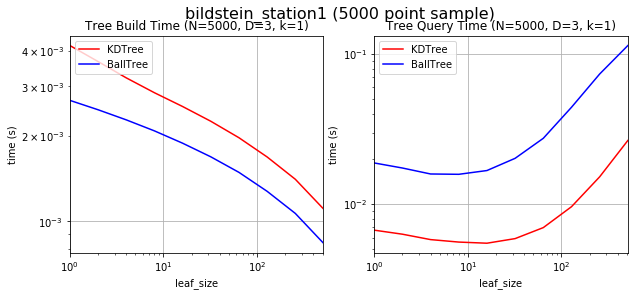

In [69]:
leaf_size = 2 ** np.arange(10)
fig, ax = plot_scaling(rand_arr1, leaf_size=leaf_size, suptitle='bildstein_station1 (5000 point sample)')

In [74]:
fig.savefig(os.path.join(LOGS_PATH, 'bps-leaf-size.svg'), format='svg', dpi=1200)
fig.savefig(os.path.join(LOGS_PATH, 'bps-leaf-size.eps'), format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


# Checking results: sg27_station9
Let's effectively check the results. We're going to compare the time it takes to bps encode sg27_station9_intensity_rgb at leaf=1 vs leaf=16.

In [123]:
from timeit import default_timer as timer
import time

In [134]:
times = []
for i in range(0,5):
    start = timer()
    bps.encode(arr1, n_bps_points=BPS_POINTS, radius=1.5, verbose=False, nn_algo='ball_tree', leaf_size=1)
    bps.encode(arr2, n_bps_points=BPS_POINTS, radius=1.5, verbose=False, nn_algo='ball_tree', leaf_size=1)
    end = timer()
    times.append(end-start)
print(times)
avg_time = 0
for i in range(0,5):
    avg_time += times[i]
avg_time = avg_time/5
print(avg_time)

[41.818429360864684, 42.02015702310018, 42.066062551923096, 42.1814090909902, 42.92274543410167]
42.20176069219597


In [135]:
times = []
for i in range(0,5):
    start = timer()
    bps.encode(arr1, n_bps_points=BPS_POINTS, radius=1.5, verbose=False, nn_algo='kd_tree', leaf_size=16)
    bps.encode(arr2, n_bps_points=BPS_POINTS, radius=1.5, verbose=False, nn_algo='kd_tree', leaf_size=16)
    end = timer()
    times.append(end-start)
print(times)
avg_time = 0
for i in range(0,5):
    avg_time += times[i]
avg_time = avg_time/5
print(avg_time)

[35.85178986284882, 34.48062887578271, 35.08722396497615, 35.725946560967714, 35.83680191705935]
35.39647823632695


# Checking results: bildstein_station1 (averaged over 20 iterations)

In [139]:
times = []
for i in range(0,20):
    start = timer()
    bps.encode(arr1, n_bps_points=BPS_POINTS, radius=1.5, verbose=False, nn_algo='ball_tree', leaf_size=1)
    bps.encode(arr2, n_bps_points=BPS_POINTS, radius=1.5, verbose=False, nn_algo='ball_tree', leaf_size=1)
    end = timer()
    times.append(end-start)
print(times)
avg_time = 0
for i in range(0,5):
    avg_time += times[i]
avg_time = avg_time/5
print(avg_time)

[2.3427306720986962, 2.2661423650570214, 2.266511157853529, 2.279394911136478, 2.3241101058665663, 2.3312874529510736, 2.2917329219635576, 2.2609258559532464, 2.256915651028976, 2.288164123892784, 2.2967502831015736, 2.233449926832691, 2.2453691149130464, 2.2385345499496907, 2.250426970887929, 2.2317263369914144, 2.219952041981742, 2.2409880249761045, 2.2481608390808105, 2.242741033202037]
2.295777842402458


In [140]:
times = []
for i in range(0,20):
    start = timer()
    bps.encode(arr1, n_bps_points=BPS_POINTS, radius=1.5, verbose=False, nn_algo='kd_tree', leaf_size=1)
    bps.encode(arr2, n_bps_points=BPS_POINTS, radius=1.5, verbose=False, nn_algo='kd_tree', leaf_size=1)
    end = timer()
    times.append(end-start)
print(times)
avg_time = 0
for i in range(0,5):
    avg_time += times[i]
avg_time = avg_time/5
print(avg_time)

[2.4182888460345566, 2.4171240099240094, 2.4179588488768786, 2.347548616118729, 2.423116086050868, 2.43389923684299, 2.391496372874826, 2.4205915951170027, 2.4045747600030154, 2.3938341338653117, 2.435899621108547, 2.439041820121929, 2.435716386884451, 2.3905664042104036, 2.379956719931215, 2.426694389199838, 2.4892427530139685, 2.5328544408548623, 2.495426671113819, 2.4771515149623156]
2.404807281401008


In [141]:
times = []
for i in range(0,20):
    start = timer()
    bps.encode(arr1, n_bps_points=BPS_POINTS, radius=1.5, verbose=False, nn_algo='ball_tree', leaf_size=16)
    bps.encode(arr2, n_bps_points=BPS_POINTS, radius=1.5, verbose=False, nn_algo='ball_tree', leaf_size=16)
    end = timer()
    times.append(end-start)
print(times)
avg_time = 0
for i in range(0,5):
    avg_time += times[i]
avg_time = avg_time/5
print(avg_time)

[2.0075941239483654, 2.077341122087091, 2.1250208530109376, 2.091560506960377, 2.113582919118926, 2.0947005818597972, 2.0967436619102955, 2.104548803064972, 2.070091071072966, 2.0791625229176134, 2.0867732111364603, 2.0550727788358927, 2.0701187250670046, 2.080479715950787, 2.047789068194106, 2.0930202200543135, 2.0767735987901688, 2.0759532109368593, 2.084595530992374, 2.1011007111519575]
2.0830199050251395


In [142]:
times = []
for i in range(0,20):
    start = timer()
    bps.encode(arr1, n_bps_points=BPS_POINTS, radius=1.5, verbose=False, nn_algo='kd_tree', leaf_size=16)
    bps.encode(arr2, n_bps_points=BPS_POINTS, radius=1.5, verbose=False, nn_algo='kd_tree', leaf_size=16)
    end = timer()
    times.append(end-start)
print(times)
avg_time = 0
for i in range(0,5):
    avg_time += times[i]
avg_time = avg_time/5
print(avg_time)

[1.9751061259303242, 2.0136518999934196, 1.9762429888360202, 2.0097493259236217, 1.9591637789271772, 1.9342948058620095, 2.0036214070860296, 2.0368649850133806, 1.999724600929767, 1.9738658689893782, 1.9157133279368281, 1.9450246698688716, 1.9497118359431624, 1.9476312699262053, 1.9598961670417339, 1.9375844851601869, 1.956747846212238, 1.9631553920917213, 1.944332828046754, 1.9777503449004143]
1.9867828239221126


In [143]:
times = []
for i in range(0,20):
    start = timer()
    bps.encode(arr1, n_bps_points=BPS_POINTS, radius=1.5, verbose=False, nn_algo='kd_tree', leaf_size=20)
    bps.encode(arr2, n_bps_points=BPS_POINTS, radius=1.5, verbose=False, nn_algo='kd_tree', leaf_size=20)
    end = timer()
    times.append(end-start)
print(times)
avg_time = 0
for i in range(0,5):
    avg_time += times[i]
avg_time = avg_time/5
print(avg_time)

[1.958109982078895, 1.9985668088775128, 1.982979424064979, 2.021102205850184, 1.9762013091240078, 2.0139671477954835, 1.9724452421069145, 1.9715924041811377, 2.000730602070689, 1.9759474999736995, 1.955112110124901, 1.983909998089075, 1.9307141660246998, 2.0441802460700274, 2.018104629823938, 2.0048160061705858, 1.985454604960978, 1.9789073360152543, 1.9964434809517115, 1.9325820470694453]
1.9873919459991156


In [144]:
times = []
for i in range(0,20):
    start = timer()
    bps.encode(arr1, n_bps_points=BPS_POINTS, radius=1.5, verbose=False, nn_algo='ball_tree', leaf_size=20)
    bps.encode(arr2, n_bps_points=BPS_POINTS, radius=1.5, verbose=False, nn_algo='ball_tree', leaf_size=20)
    end = timer()
    times.append(end-start)
print(times)
avg_time = 0
for i in range(0,5):
    avg_time += times[i]
avg_time = avg_time/5
print(avg_time)

[2.11403086502105, 2.037694541970268, 2.1179605599027127, 2.040586719987914, 2.0404245229437947, 2.0461866420228034, 2.062804973917082, 2.0708449261728674, 2.0521253480110317, 2.0375260789878666, 2.101241334108636, 2.094117796048522, 2.080541891977191, 2.079733360093087, 2.08913405216299, 2.0873068768996745, 2.065268555888906, 2.109619462862611, 2.0617629180196673, 2.067338441964239]
2.0701394419651478


In [145]:
times = []
for i in range(0,20):
    start = timer()
    bps.encode(arr1, n_bps_points=BPS_POINTS, radius=1.5, verbose=False, nn_algo='kd_tree', leaf_size=13)
    bps.encode(arr2, n_bps_points=BPS_POINTS, radius=1.5, verbose=False, nn_algo='kd_tree', leaf_size=13)
    end = timer()
    times.append(end-start)
print(times)
avg_time = 0
for i in range(0,5):
    avg_time += times[i]
avg_time = avg_time/5
print(avg_time)

[1.9897101069800556, 1.9948430589865893, 1.9560316759161651, 2.026274789823219, 2.0224141059443355, 2.020655896048993, 2.032958230935037, 2.041997147956863, 2.041607012040913, 2.0088770710863173, 2.0128794389311224, 1.9575334580149502, 1.9849102338775992, 2.0725645830389112, 1.9548201230354607, 1.995720338774845, 2.035283137112856, 2.0205181878991425, 1.992012932896614, 2.03433910314925]
1.997854747530073


In [146]:
times = []
for i in range(0,20):
    start = timer()
    bps.encode(arr1, n_bps_points=BPS_POINTS, radius=1.5, verbose=False, nn_algo='ball_tree', leaf_size=13)
    bps.encode(arr2, n_bps_points=BPS_POINTS, radius=1.5, verbose=False, nn_algo='ball_tree', leaf_size=13)
    end = timer()
    times.append(end-start)
print(times)
avg_time = 0
for i in range(0,5):
    avg_time += times[i]
avg_time = avg_time/5
print(avg_time)

[1.9752928880043328, 2.0018250818829983, 2.018732452997938, 2.0038379749748856, 2.0476741131860763, 2.0323531760368496, 2.039780702907592, 2.020600089104846, 2.0662258421070874, 2.0509840280283242, 2.065131837967783, 2.049207189818844, 2.034029522910714, 2.026571804191917, 1.989914788864553, 2.0330039621330798, 2.0704962441232055, 1.9830942910630256, 2.0399646961595863, 1.9792838289868087]
2.0094725022092463
